In [35]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import functions
from preprocess_dataframe import get_preprocess_dataframe
import os
import re
import glob
import math
import plotly.graph_objs as go
from shutil import copyfile
import time

In [209]:
def readcsv(args):
    return pd.read_csv(args, header=None)

def get_df(path_folder, file_name, mode, times):
    df = pd.DataFrame()
    if times>1:
        csv_files = glob.glob(path_folder + "/*.csv")
        df_list = (pd.read_csv(file) for file in csv_files)
        df   = pd.concat(df_list, ignore_index=True)
    else:
        df = pd.read_csv('{}/{}'.format(path_folder,file_name))
    df = df.fillna(0)
    df=df.rename(columns={'Plan time': 'plan_time'})
    df = df.rename(columns = {'Query Number':'query_number', 'Query Name':'query_name', 'Execution Time':'execution_time', 'Query hash':'query_hash'})
    df['query_number'] = df['query_number'].astype(int)
    df['query_hash'] = df['query_hash'].astype(str)
    df['plan_time'] = df['plan_time'].astype(float)
    if times>1:
        lst_data = []
        dict_query = {}
        for i in df.itertuples(index=False):
            if i.query_name in dict_query:
                dict_query[i.query_name][1] += i.execution_time
                dict_query[i.query_name][3] += i.plan_time
            else:
                dict_query[i.query_name] = [i.query_name, i.execution_time, i.query_hash, i.plan_time]
        df = pd.DataFrame(dict_query.values(), columns = ['query_name', 'execution_time', 'query_hash', 'plan_time'])
        df['exec_time_avg'] = df['execution_time']/times
        df['plan_time_avg'] = df['plan_time']/times
    return df

In [317]:
df_control = get_df('/home/alena/Yandex.Disk/aqo/test/jo-bench/frozen_folder3','frozen_1_report.csv', 'control', 1)

In [318]:
df_control

,query_number,query_name,execution_time,plan_time,query_hash
0,1,10a.sql,328.797,30.142,-6651533820180303979
1,1,10b.sql,131.953,30.299,988535410010893112
2,1,10c.sql,10621.225,22.903,2494719406442254794
3,1,11a.sql,65.863,74.659,-8754961486292191806
4,1,11b.sql,27.404,73.609,7102013096890644952
...,...,...,...,...,...
108,1,8d.sql,2945.220,35.449,-2444720784039749802
109,1,9a.sql,477.870,95.950,-6747521538659772949
110,1,9b.sql,1838.737,78.185,316739818532851506
111,1,9c.sql,524.584,63.783,-180252288200201541


In [319]:
df_disabled = get_df('/home/alena/Yandex.Disk/aqo/test/jo-bench/disabled_folder3', 'disabled_1_report.csv', 'disabled', 1)

In [320]:
df_learn = get_df('/home/alena/Yandex.Disk/aqo/test/jo-bench/learn_folder3', '14_job_onepass_result_learn.csv', 'learn', 9)

In [321]:
df_learn

,query_name,execution_time,query_hash,plan_time,exec_time_avg,plan_time_avg
0,10a.sql,2968.613,-6.651533820180304e+18,305.272,329.845889,33.919111
1,10b.sql,1248.258,9.88535410010893e+17,267.653,138.695333,29.739222
2,10c.sql,100598.693,2.494719406442255e+18,256.058,11177.632556,28.450889
3,11a.sql,1689.949,-8.754961486292192e+18,634.113,187.772111,70.457000
4,11b.sql,258.717,7.102013096890644e+18,570.574,28.746333,63.397111
...,...,...,...,...,...,...
109,9a.sql,7902.024,-6.747521538659773e+18,785.061,878.002667,87.229000
110,9b.sql,19321.296,3.167398185328515e+17,710.891,2146.810667,78.987889
111,9c.sql,5169.131,-1.8025228820020154e+17,629.714,574.347889,69.968222
112,9d.sql,87234.268,7.221379846823333e+18,602.069,9692.696444,66.896556


In [216]:
def renames(df, mode):
    df = df.rename(columns = {'plan_time':'plan_time_{}'.format(mode), 'execution_time':'execution_time_{}'.format(mode)})
    if mode == 'control' or mode == 'disabled':
        df = df.rename(columns = {'plan_time_avg':'plan_time_avg_{}'.format(mode), 'exec_time_avg':'exec_time_avg_{}'.format(mode)})
    return df

In [217]:
df_disabled = renames(df_disabled, 'disabled')

In [218]:
df_control = renames(df_control, 'control')

In [219]:
df_learn = renames(df_learn, 'learn')

In [220]:
df = df_disabled.merge(df_control, how='left', on='query_name')

In [221]:
df

,query_number_x,query_name,execution_time_disabled,plan_time_disabled,query_hash_x,query_number_y,execution_time_control,plan_time_control,query_hash_y
0,1,10a.sql,644.338,21.385,-6651533820180303979,1,328.797,30.142,-6651533820180303979
1,1,10b.sql,91.390,12.484,988535410010893112,1,131.953,30.299,988535410010893112
2,1,10c.sql,12046.649,16.326,2494719406442254794,1,10621.225,22.903,2494719406442254794
3,1,11a.sql,343.421,31.394,-8754961486292191806,1,65.863,74.659,-8754961486292191806
4,1,11b.sql,31.649,26.693,7102013096890644952,1,27.404,73.609,7102013096890644952
...,...,...,...,...,...,...,...,...,...
108,1,8d.sql,3030.756,17.412,-2444720784039749802,1,2945.220,35.449,-2444720784039749802
109,1,9a.sql,4627.037,33.123,-6747521538659772949,1,477.870,95.950,-6747521538659772949
110,1,9b.sql,1680.730,29.709,316739818532851506,1,1838.737,78.185,316739818532851506
111,1,9c.sql,605.685,27.055,-180252288200201541,1,524.584,63.783,-180252288200201541


In [322]:
dict_hash = {}
for i in df_disabled.itertuples(index=False):
    if i.query_hash in dict_hash:
        dict_hash[i.query_hash].append(i.query_name)
    else:
        dict_hash[i.query_hash] = []
        dict_hash[i.query_hash].append(i.query_name)

In [323]:
dict_hash

{'-6651533820180303979': ['10a.sql'],
 '988535410010893112': ['10b.sql'],
 '2494719406442254794': ['10c.sql'],
 '-8754961486292191806': ['11a.sql'],
 '7102013096890644952': ['11b.sql'],
 '2333270921735776355': ['11c.sql'],
 '-5951735317690032369': ['11d.sql'],
 '-9026514954839072455': ['12a.sql'],
 '5632455736553151255': ['12b.sql'],
 '6417179009749033666': ['12c.sql'],
 '-1829334865866162189': ['13a.sql'],
 '4778871310081631647': ['13b.sql', '13c.sql'],
 '2434959201386717317': ['13d.sql'],
 '274192810335693858': ['14a.sql'],
 '-4506995590541967356': ['14b.sql'],
 '299267792258938541': ['14c.sql'],
 '-460740518707800565': ['15a.sql'],
 '-4209927756710409746': ['15b.sql'],
 '4486446217020337985': ['15c.sql'],
 '-321921298358758659': ['15d.sql'],
 '816913887554954199': ['16a.sql', '16d.sql'],
 '3350265702090035455': ['16b.sql'],
 '607840843579539521': ['16c.sql'],
 '-917204397272063480': ['17a.sql'],
 '-5459870143170781696': ['17b.sql', '17c.sql'],
 '3199076743843001296': ['17d.sql', '17

In [107]:
import plotly.graph_objs as go
from shutil import copyfile
import time

In [197]:
ox = df['query_name']

In [198]:
df

,query_number_x,query_name,execution_time_disabled,plan_time_disabled,query_hash_x,query_number_y,execution_time_control,plan_time_control,query_hash_y
0,1,10a.sql,373.026,23.894,-6651533820180303979,1,286.440,35.239,-6651533820180303979
1,1,10b.sql,99.683,15.867,988535410010893112,1,113.217,27.764,988535410010893112
2,1,10c.sql,10347.484,14.691,2494719406442254794,1,10772.735,25.173,2494719406442254794
3,1,11a.sql,103.606,28.663,-8754961486292191806,1,75.022,59.129,-8754961486292191806
4,1,11b.sql,23.883,26.651,7102013096890644952,1,22.416,54.470,7102013096890644952
...,...,...,...,...,...,...,...,...,...
108,1,8d.sql,3017.692,19.965,-2444720784039749802,1,2352.914,28.650,-2444720784039749802
109,1,9a.sql,4277.794,28.709,-6747521538659772949,1,276.623,71.519,-6747521538659772949
110,1,9b.sql,1614.635,33.849,316739818532851506,1,1648.705,61.140,316739818532851506
111,1,9c.sql,475.856,26.785,-180252288200201541,1,472.023,57.103,-180252288200201541


In [510]:
df['better_worse']=((df['plan_time_disabled']-df['plan_time_control'])/df['plan_time_disabled'])*100

In [511]:
lst_cond=[]
for i in df['better_worse']:
    if i < 0 and i > -10:
        lst_cond.append('df_less0_10')
    elif i <= -10 and i > -25:
        lst_cond.append('df_less10_25')
    elif i <= -25 and i > -50:
        lst_cond.append('df_less25_50')
    elif i <= -50 and i > -75:
        lst_cond.append('df_less50_75')
    elif i <= -75:
        lst_cond.append('df_less75_100')
    elif i >= 0 and i < 10:
        lst_cond.append('df_more0_10')
    elif i >= 10 and i < 25:
        lst_cond.append('df_more10_25')
    elif i >= 25 and i < 50:
        lst_cond.append('df_more25_50')
    elif i >= 50 and i < 75:
        lst_cond.append('df_more50_75')
    elif i >= 75:
        lst_cond.append('df_more75_100')

In [512]:
df['condition']=lst_cond

In [513]:
lst_groups=['df_less0_10','df_less10_25','df_less25_50','df_less50_75','df_less75_100', 'df_more0_10', 'df_more10_25','df_more25_50', 'df_more50_75', 'df_more75_100']

In [514]:
sum_=0
for i in lst_groups:
    sum_+=len(df[df['condition']==i])
    print(i, len(df[df['condition']==i]))
print(sum_)

df_less0_10 0
df_less10_25 0
df_less25_50 11
df_less50_75 15
df_less75_100 84
df_more0_10 0
df_more10_25 3
df_more25_50 0
df_more50_75 0
df_more75_100 0
113


In [424]:
import re

In [508]:
from shutil import copyfile
import time

Graphics execution:

In [515]:
for elem in lst_groups:
    df_cond = df[df['condition']==elem]
    digits=re.findall(r'(\d+)', elem)
    if 'less' in elem:
        name='Время выполнения запроса с AQO и без от -{} до -{}'.format(digits[0], digits[1])
        filename='plan_less{}_{}'.format(digits[0], digits[1])
    else:
        name='Время выполнения запроса с AQO и без от {} до {}'.format(digits[0], digits[1])
        filename='plan_more{}_{}'.format(digits[0], digits[1])
    fig = go.Figure()
    fig.add_trace(go.Bar(name='control', x=df_cond['query_name'], y=np.log10(df_cond['plan_time_control']), text=round(df_cond['plan_time_control'],2)))
    fig.add_trace(go.Bar(name = 'disable', x=df_cond['query_name'], y=np.log10(df_cond['plan_time_disabled']), text=round(df_cond['plan_time_disabled'],2)))
    fig.update_layout(title = name, width=1500, height = 500)
    plotly.offline.plot(fig, image_filename=filename, image='svg')
    time.sleep(1)
    os.replace('{}/{}.svg'.format('/home/alena/Downloads', filename), '{}/{}.svg'.format('/home/alena/Yandex.Disk/aqo/test/jo-bench/frozen_folder3', filename))
    #copyfile('{}/{}.svg'.format('/home/alena/Downloads', filename),
    #     '{}/{}.svg'.format('/home/alena/Yandex.Disk/aqo/test/jo-bench/frozen_folder3', filename))
    #os.replace("~/Downloads/'{}'.svg".format(name), "{}/'{}'.svg".format('/home/alena/Yandex.Disk/aqo/test/jo-bench/frozen_folder3', name))
    #fig.show()

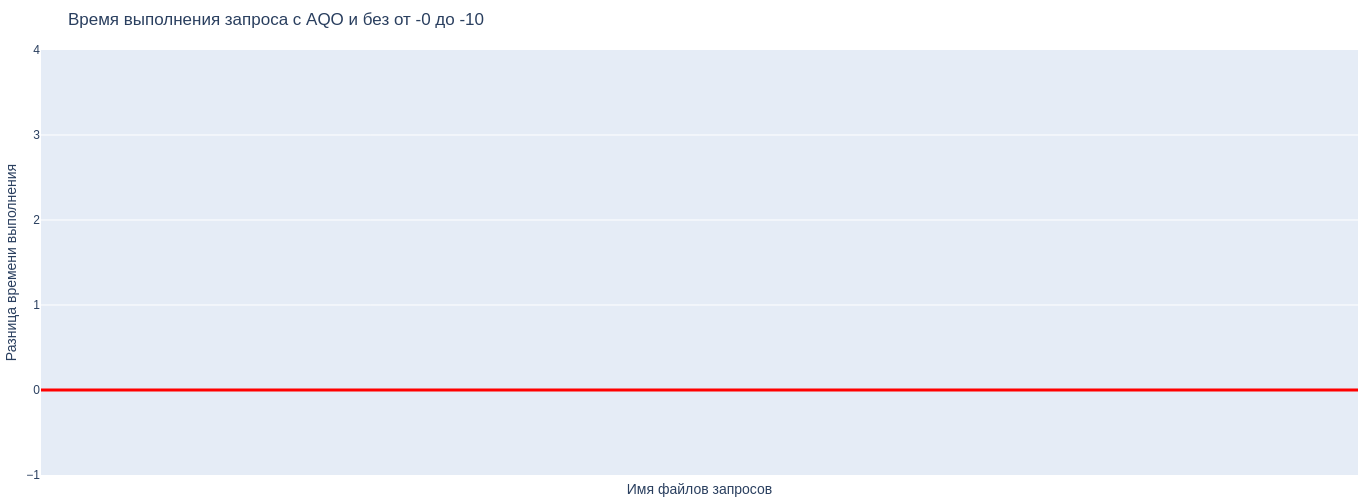

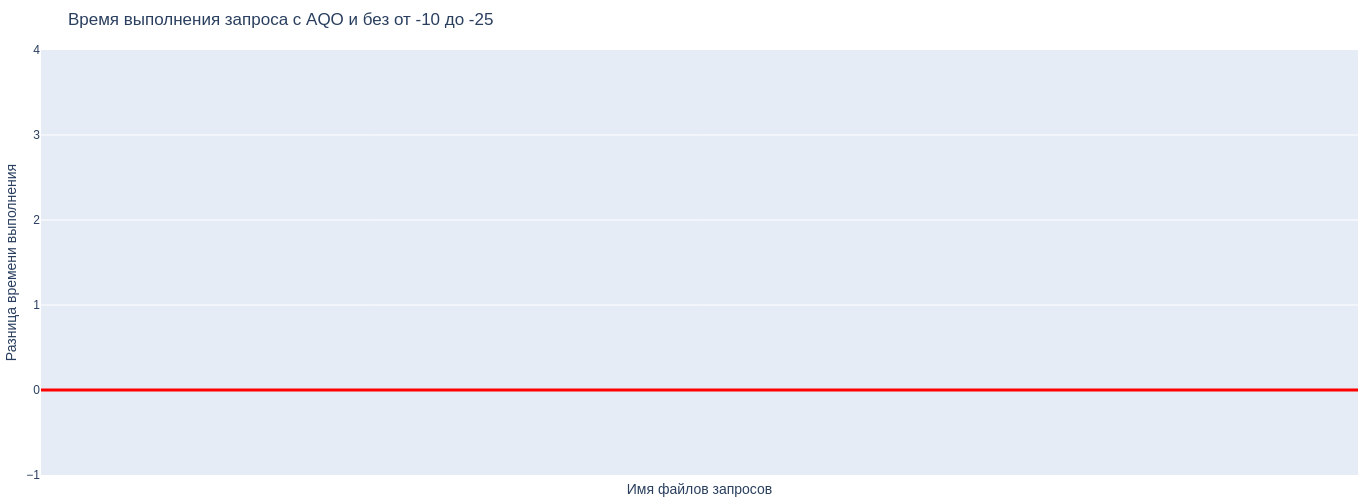

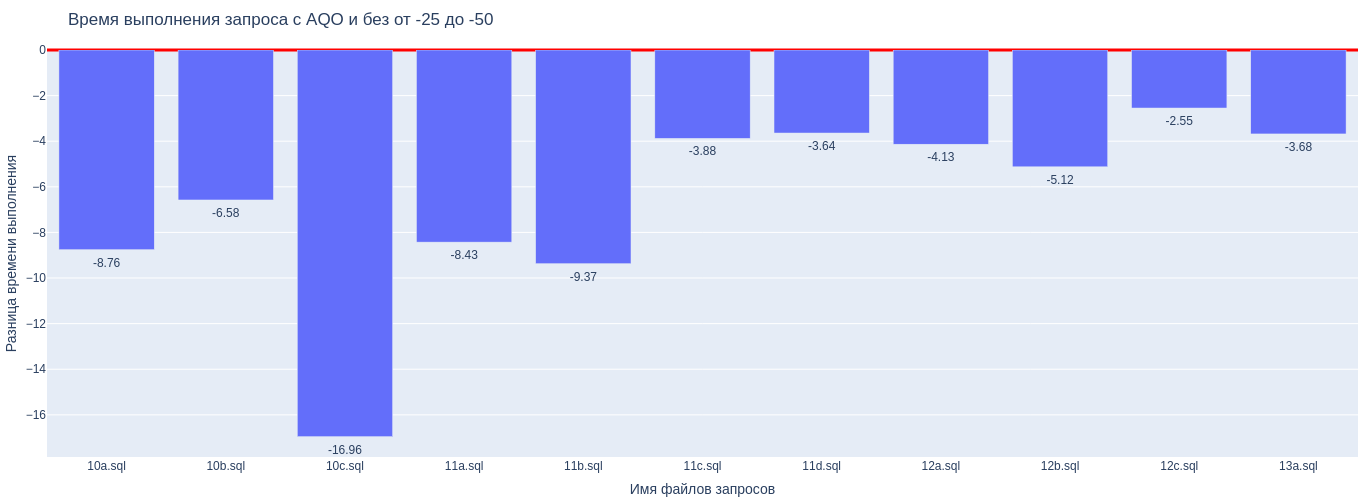

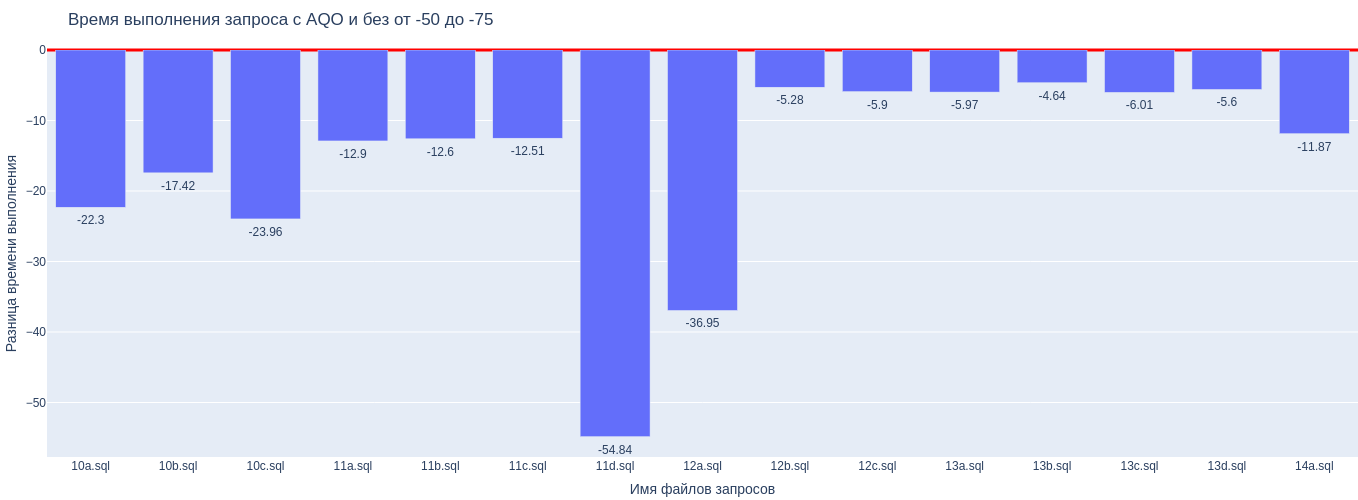

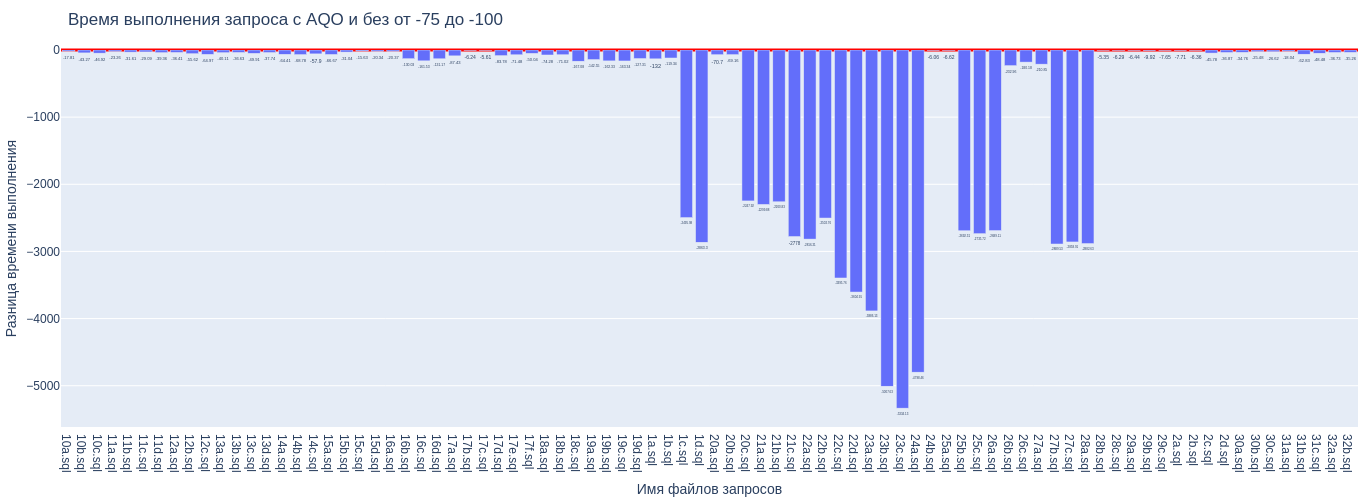

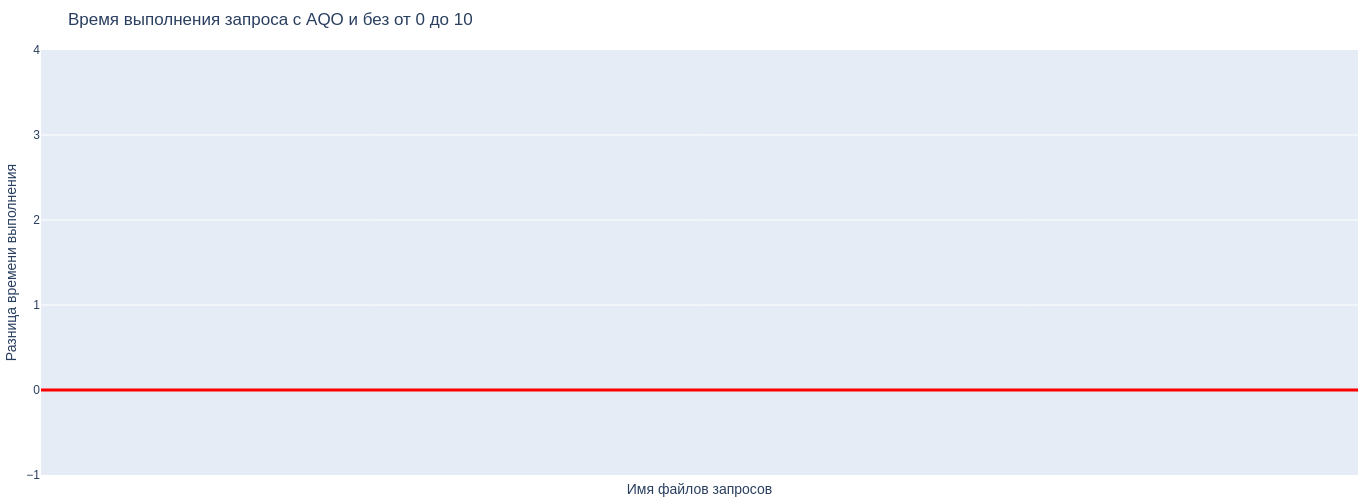

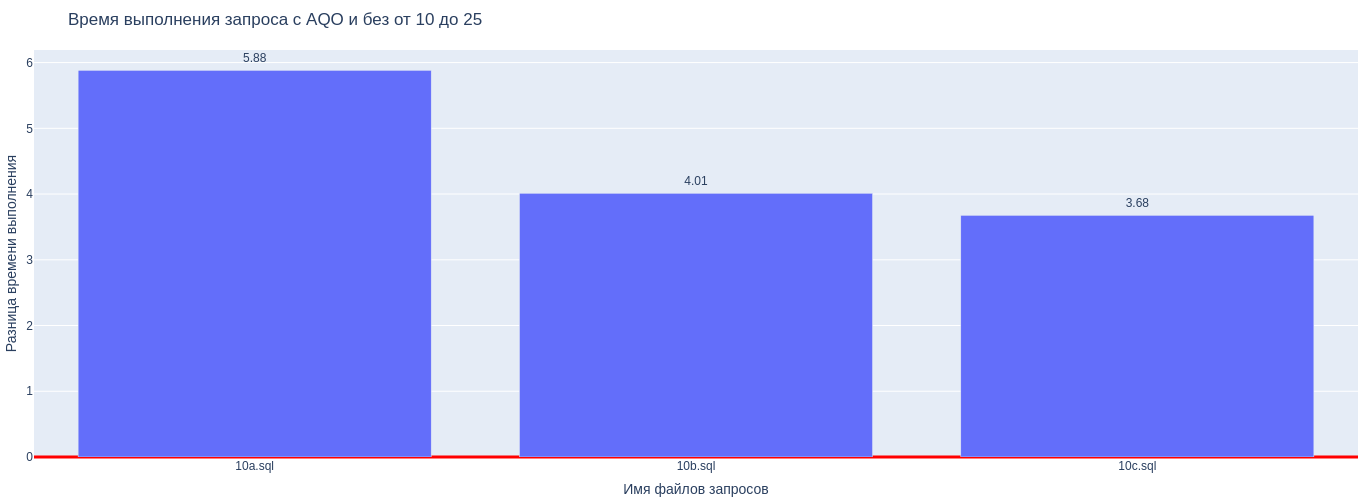

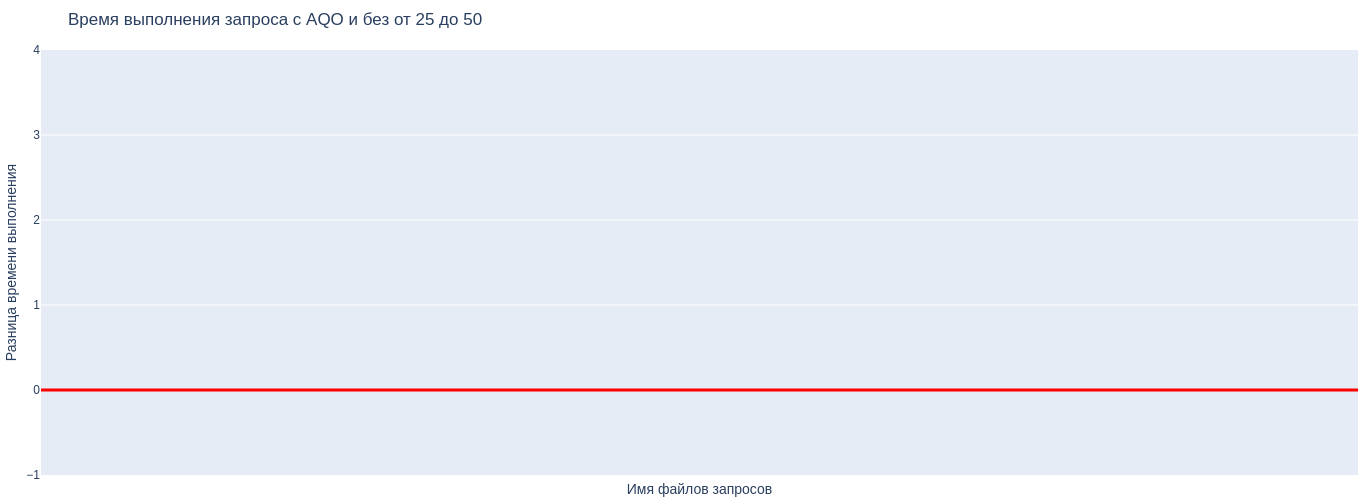

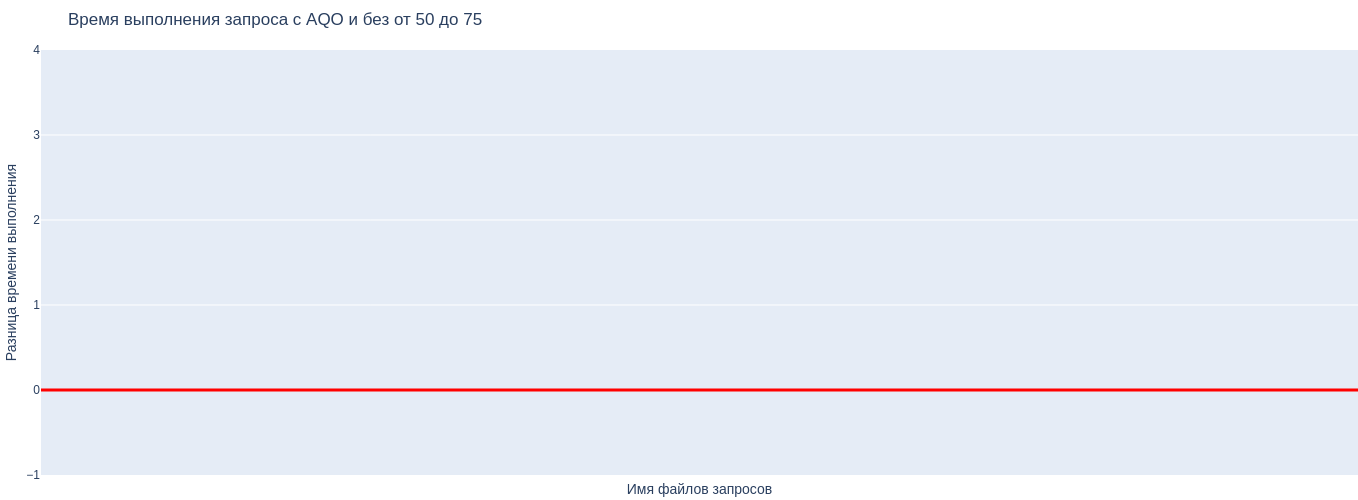

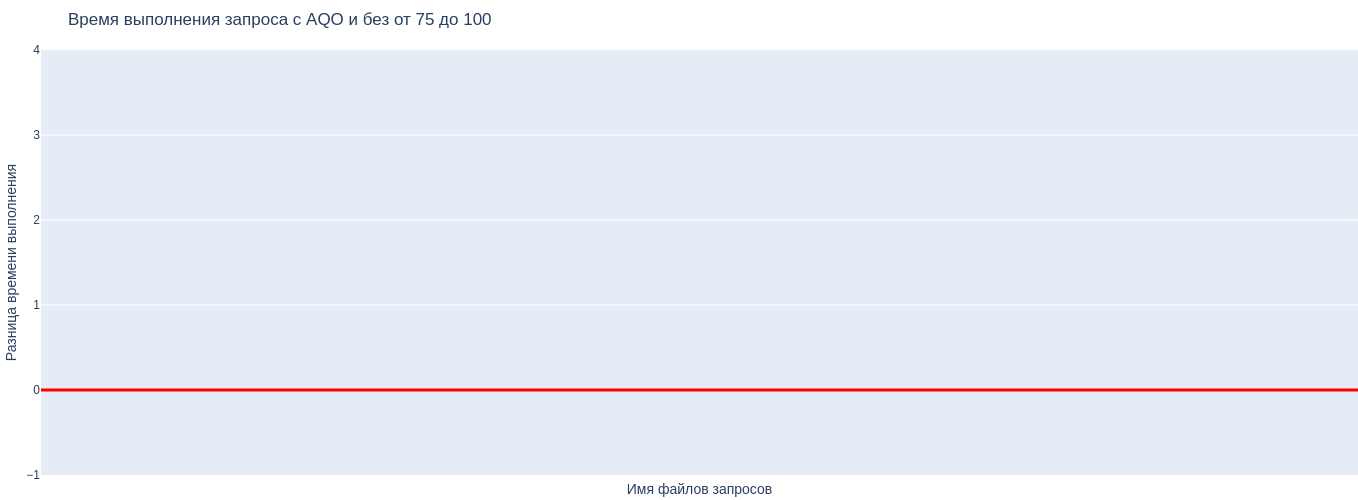

In [519]:
for elem in lst_groups:
    df_cond = df[df['condition']==elem]
    digits=re.findall(r'(\d+)', elem)
    if 'less' in elem:
        name='Время выполнения запроса с AQO и без от -{} до -{}'.format(digits[0], digits[1])
        filename='plan_less{}_{}'.format(digits[0], digits[1])
    else:
        name='Время выполнения запроса с AQO и без от {} до {}'.format(digits[0], digits[1])
        filename='plan_more{}_{}'.format(digits[0], digits[1])
    fig = go.Figure()
    fig.add_trace(go.Bar(x = ox, y = df_cond['plan_time_disabled'] - df_cond['plan_time_control'], text=round(df_cond['plan_time_disabled'] - df_cond['plan_time_control'],2), textposition='outside'))
    fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    fig.update_layout(legend_orientation="h",
                      legend=dict(x=.5, xanchor="center"),
                      title=name,
                      xaxis_title="Имя файлов запросов",
                      yaxis_title="Разница времени выполнения",
                      margin=dict(l=0, r=0, t=50, b=0))
    fig.update_layout(width=1500, height = 500)
    fig.show()

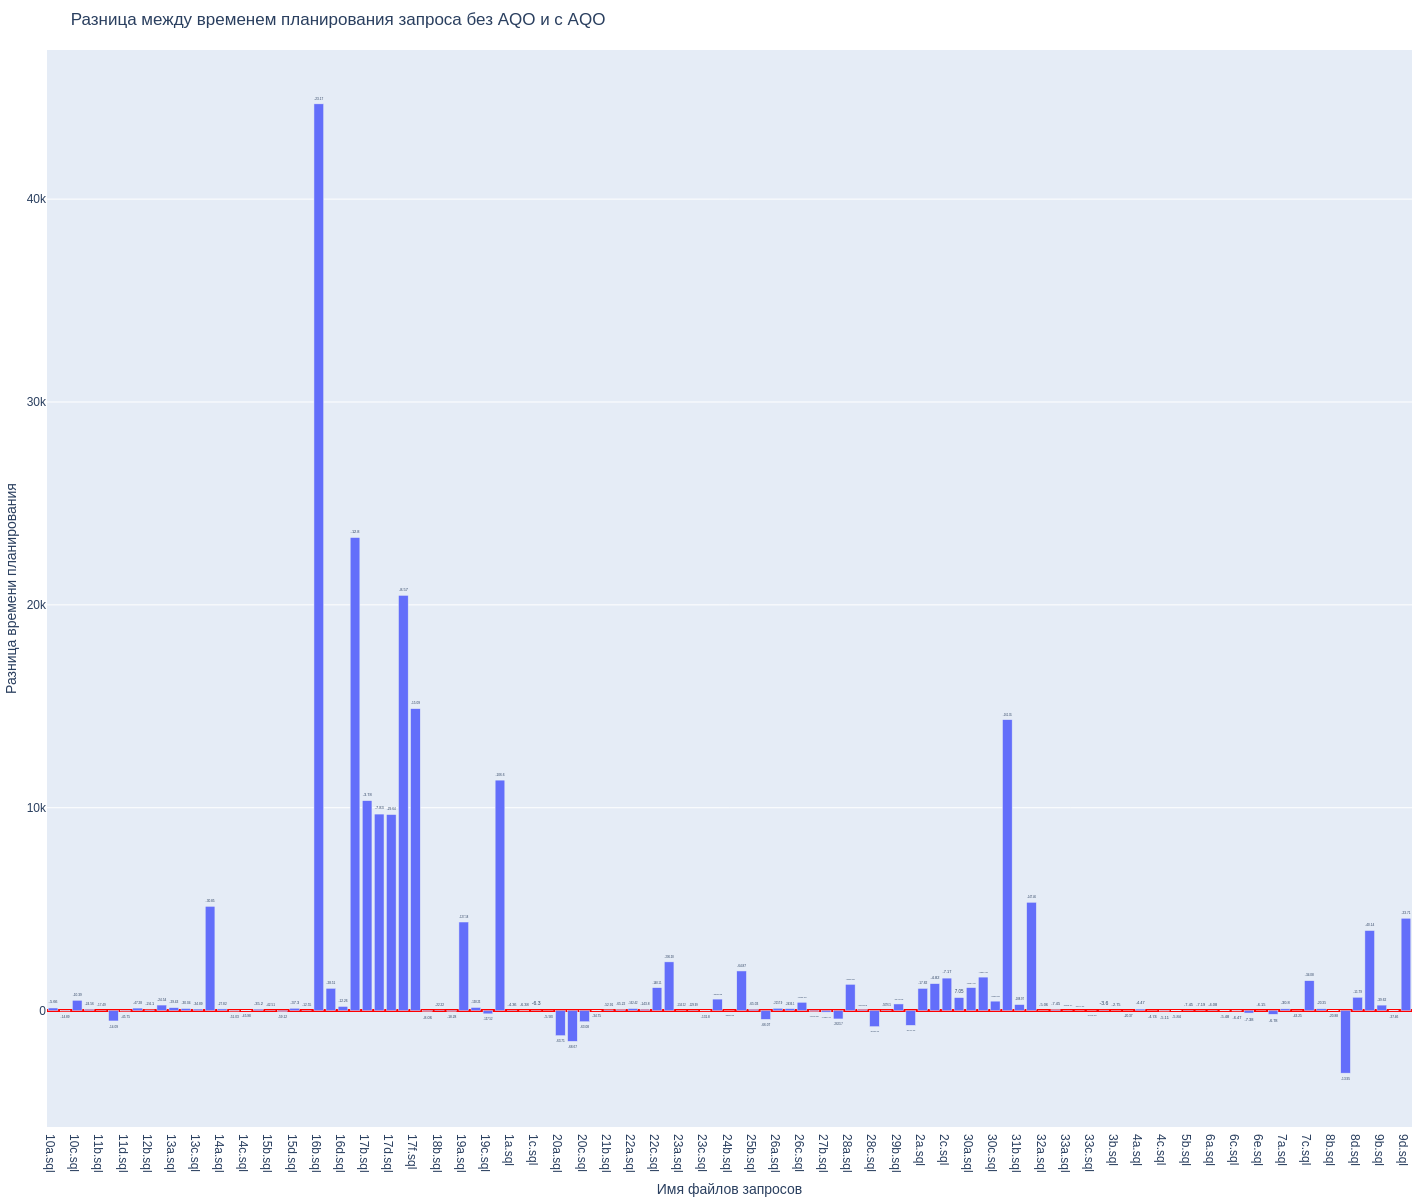

In [85]:
fig = go.Figure()
fig.add_trace(go.Bar(x = ox, y = val_disable - val_control, text=round(df['plan_time_avg_disabled'] - df['plan_time_control'],2), textposition='outside'))
fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Разница между временем планирования запроса без AQO и с AQO",
                  xaxis_title="Имя файлов запросов",
                  yaxis_title="Разница времени планирования",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

In [154]:
df

,query_name,execution_time_disabled,query_hash_x,plan_time_disabled,exec_time_avg_disabled,plan_time_avg_disabled,query_number,execution_time_control,query_hash_y,plan_time_control
0,10a.sql,12.692,-8466900092379851356,127.706,0.63460,6.38530,1583,0.391,-8466900092379851356,14.719
1,10b.sql,12.040,2774380343033967657,127.626,0.60200,6.38130,1584,0.375,2774380343033967657,13.843
2,10c.sql,12.798,-4251956997982051954,129.963,0.63990,6.49815,1585,0.422,-4251956997982051954,13.505
3,11a.sql,13.546,-5488040680994451542,204.996,0.67730,10.24980,1586,0.464,-5488040680994451542,27.437
4,11b.sql,14.390,7394212072360742796,217.624,0.71950,10.88120,1587,0.438,7394212072360742796,27.039
...,...,...,...,...,...,...,...,...,...,...
108,8d.sql,13.472,3307219224034505636,156.109,0.67360,7.80545,1691,0.383,3307219224034505636,14.606
109,9a.sql,15.844,954242025233775480,252.664,0.79220,12.63320,1692,0.435,954242025233775480,39.813
110,9b.sql,14.572,360267341090989125,228.213,0.72860,11.41065,1693,0.584,360267341090989125,50.078
111,9c.sql,14.381,-6640292492350062322,257.679,0.71905,12.88395,1694,0.441,-6640292492350062322,34.196


In [155]:
df[(df['query_name']=='7a.sql') | (df['query_name']=='26b.sql')]

,query_name,execution_time_disabled,query_hash_x,plan_time_disabled,exec_time_avg_disabled,plan_time_avg_disabled,query_number,execution_time_control,query_hash_y,plan_time_control
61,26b.sql,13.235,-1196089802533896753,2042.284,0.66175,102.11420,1644,0.703,-1196089802533896753,1963.882
102,7a.sql,12.207,-4483314535500321943,215.023,0.61035,10.75115,1685,0.620,-4483314535500321943,27.325


поняла, во сколько быстрее время выполнения запроса без AQO по сравнению с AQO

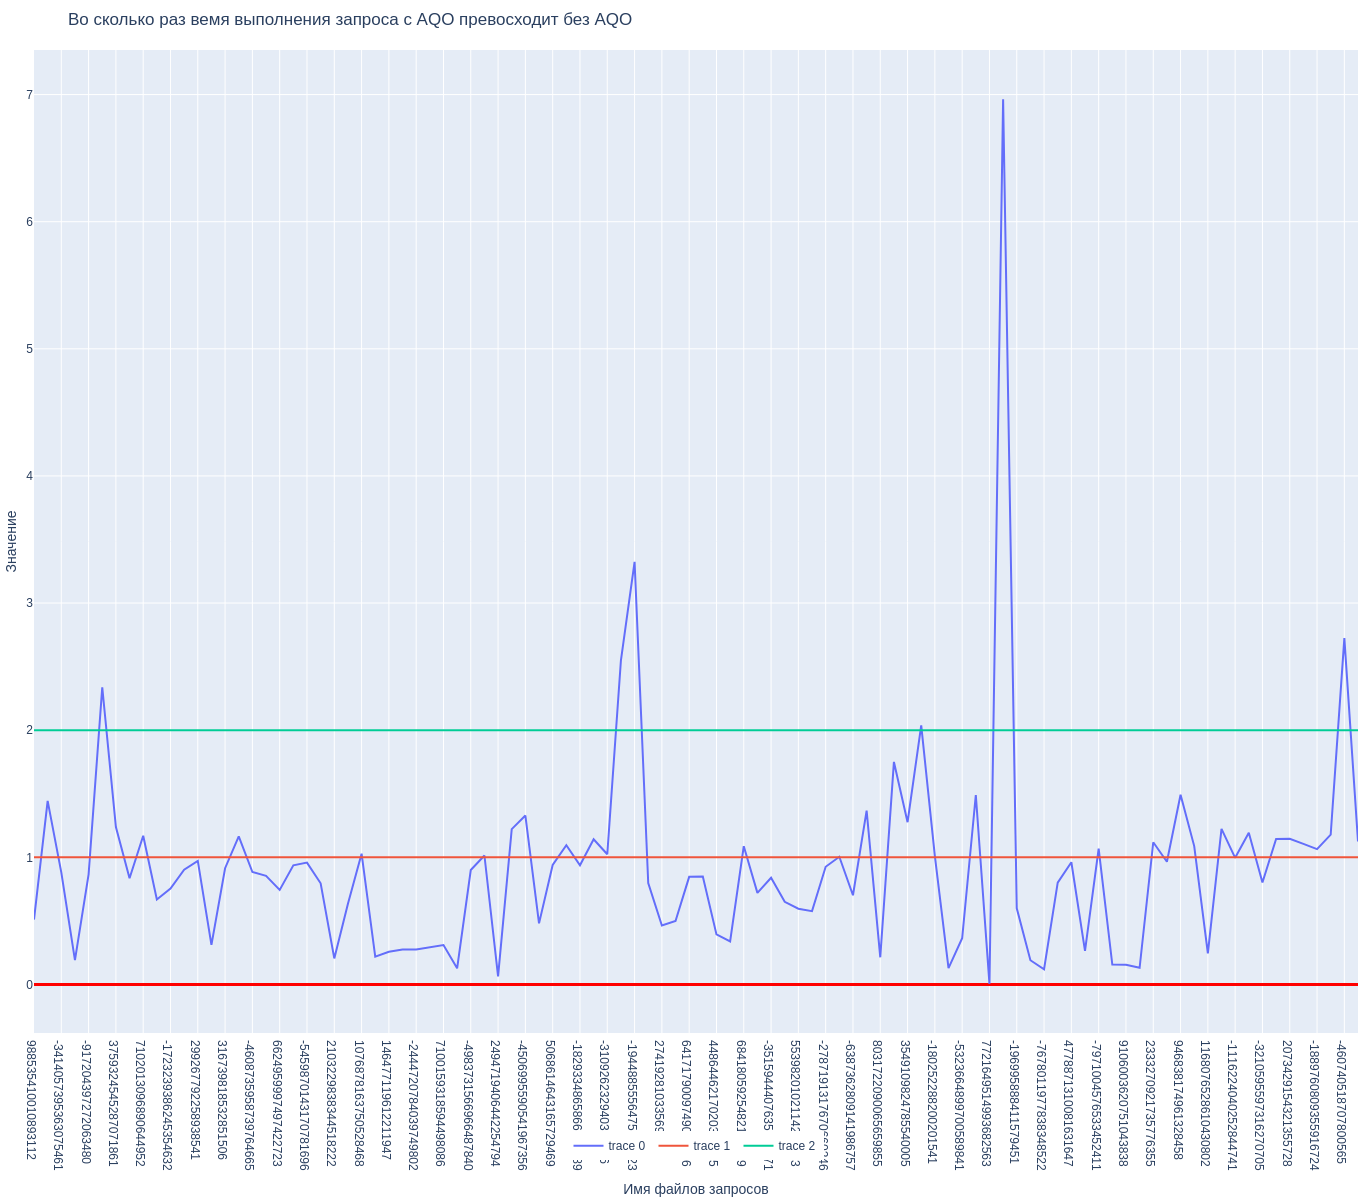

In [586]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = ox, y = val_control/val_disable))
fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Во сколько раз вемя выполнения запроса с AQO превосходит без AQO",
                  xaxis_title="Имя файлов запросов",
                  yaxis_title="Значение",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

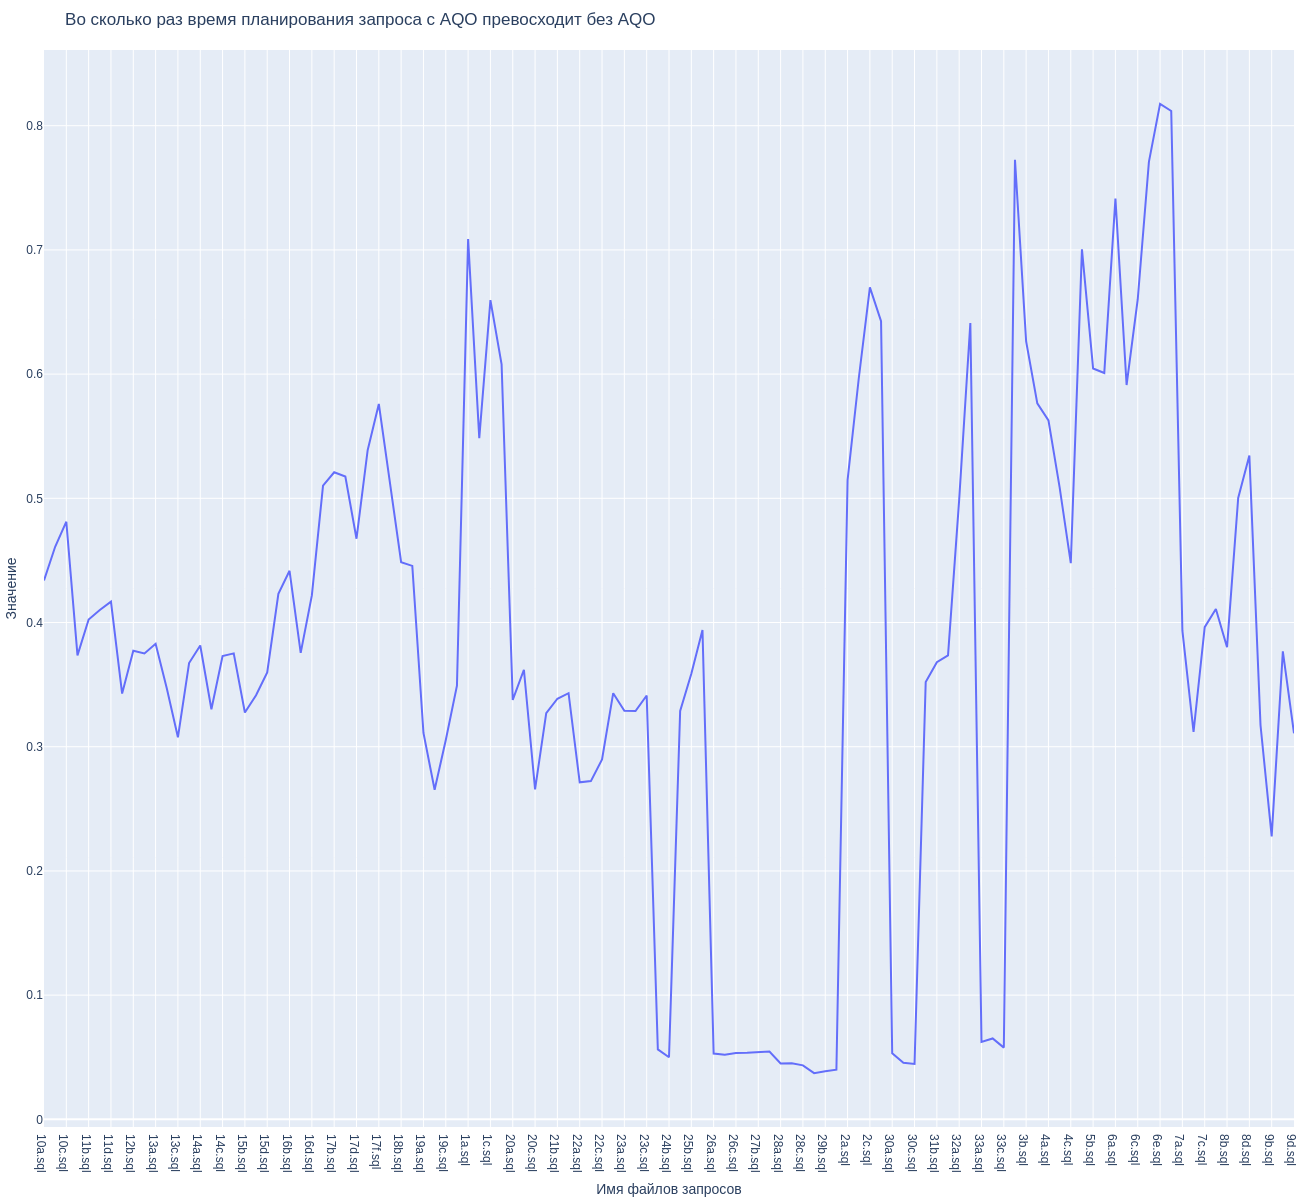

In [157]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = ox, y = df['plan_time_avg_disabled']/df['plan_time_control']))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, y = 0.4, xanchor="center"),
                  title="Во сколько раз время планирования запроса с AQO превосходит без AQO",
                  xaxis_title="Имя файлов запросов",
                  yaxis_title="Значение",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

на какой итерации сходимость

In [48]:
df_stat = pd.read_csv('/home/alena/Yandex.Disk/aqo/test/jo-bench/frozen_folder3/frozen_aqo_query_stat.csv')

In [49]:
df_stat_copy = df_stat

In [50]:
df_stat_copy

,queryid,execution_time_with_aqo,execution_time_without_aqo,planning_time_with_aqo,planning_time_without_aqo,cardinality_error_with_aqo,cardinality_error_without_aqo,executions_with_aqo,executions_without_aqo
0,988535410010893112,"{0.122344214,0.147024573,0.140277761,0.1349305...",{0.092219457},"{0.031122358,0.0271376,0.030488074,0.026549646...",{0.012401197},"{1.4385404747034312,0,0,0,0,0,0,0,0,0}",{1.172989933948849},10,1
1,-6651533820180303979,"{0.299926989,0.30791333,0.301040992,0.30295518...",{0.645729918},"{0.029951335,0.031402382,0.033399102,0.0328972...",{0.021289912},"{0.7277090632656152,0.21317332687276505,0,0,0,...",{0.712949410247023},10,1
2,-3414057395363075461,"{0.18807648,0.174565918,0.209044719,0.17392359...",{0.179500959},"{0.01504233,0.01664703,0.01876138,0.015941811,...",{0.008942713},"{1.1885889419697482,0.07701635339554948,0,0,0,...",{0.9142991861305755},10,1
3,3350265702090035455,"{57.848569877,75.365586024,103.546677593,126.0...",{61.923453419},"{0.060619619,0.064468076,0.061139899,0.0592192...",{0.031073643},"{3.3320606482785617,1.7111492912836013,1.94628...",{3.32430610149472},10,1
4,-917204397272063480,"{30.747608025,32.376212784,22.160783496,69.525...",{32.6507846},"{0.042607861,0.031872699,0.031807109,0.0348970...",{0.024932291},"{3.251750921039907,1.4715473432055728,1.861491...",{3.259902824746556},10,1
...,...,...,...,...,...,...,...,...,...
93,-6885312641126422993,"{0.108621719,0.12513054,0.099771667,0.12283240...",{0.103223085},"{0.013252802,0.015889436,0.012663574,0.0115263...",{0.007239035},"{2.4589535282085784,0.14398478283858396,0,0,0,...",{2.431867039958949},10,1
94,-1889760809355916724,"{2.715641645,2.483907225,1.742395343,18.748641...",{1.817957894},"{2.851387533,2.832536093,2.58735318,2.85339940...",{0.243446332},"{2.8238698943528595,1.9570327714827196,1.08379...",{2.8373640543804424},10,1
95,-6571914703387389993,"{10.048059622,0.046884945,0.046641239,0.190032...",{9.564133292},"{5.400078017,5.604978881,5.692204763,5.5576627...",{0.31404461},"{1.9730042238662728,0.829610623412134,0.737391...",{1.981759333102503},10,1
96,-460740518707800565,"{0.618947525,0.454309503,0.67755213,0.59856322...",{0.70043938},"{0.113077339,0.139387981,0.113923654,0.1261688...",{0.073120285},"{0.9255816624876363,0.6997441750808249,0.16834...",{0.9276715189215594},10,1


In [51]:
lst_stat_columns = ['execution_time_with_aqo', 'execution_time_without_aqo',
       'planning_time_with_aqo', 'planning_time_without_aqo',
       'cardinality_error_with_aqo', 'cardinality_error_without_aqo']
lst_stat_cut = [1, 1, 1, 1, 1, 1]

In [52]:
df_stat = get_preprocess_dataframe(df_stat, lst_stat_columns, lst_stat_cut)

/home/alena/Yandex.Disk/aqo/jo-bench/functions.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/Yandex.Disk/aqo/jo-bench/functions.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/Yandex.Disk/aqo/jo-bench/functions.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/Yandex.Disk/aqo/jo-bench/functions.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a Dat

In [53]:
df_stat

,queryid,cardinality_error_without_aqo_split,cardinality_error_with_aqo_split,planning_time_without_aqo_split,planning_time_with_aqo_split,execution_time_without_aqo_split,execution_time_with_aqo_split,executions_with_aqo,executions_without_aqo
0,988535410010893112,[1.172989933948849],"[1.4385404747034312, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[0.012401197],"[0.031122358, 0.0271376, 0.030488074, 0.026549...",[0.092219457],"[0.122344214, 0.147024573, 0.140277761, 0.1349...",10,1
1,-6651533820180303979,[0.712949410247023],"[0.7277090632656152, 0.21317332687276505, 0.0,...",[0.021289912],"[0.029951335, 0.031402382, 0.033399102, 0.0328...",[0.645729918],"[0.299926989, 0.30791333, 0.301040992, 0.30295...",10,1
2,-3414057395363075461,[0.9142991861305755],"[1.1885889419697482, 0.07701635339554948, 0.0,...",[0.008942713],"[0.01504233, 0.01664703, 0.01876138, 0.0159418...",[0.179500959],"[0.18807648, 0.174565918, 0.209044719, 0.17392...",10,1
3,3350265702090035455,[3.32430610149472],"[3.3320606482785617, 1.7111492912836013, 1.946...",[0.031073643],"[0.060619619, 0.064468076, 0.061139899, 0.0592...",[61.923453419],"[57.848569877, 75.365586024, 103.546677593, 12...",10,1
4,-917204397272063480,[3.259902824746556],"[3.251750921039907, 1.4715473432055728, 1.8614...",[0.024932291],"[0.042607861, 0.031872699, 0.031807109, 0.0348...",[32.6507846],"[30.747608025, 32.376212784, 22.160783496, 69....",10,1
...,...,...,...,...,...,...,...,...,...
93,-6885312641126422993,[2.431867039958949],"[2.4589535282085784, 0.14398478283858396, 0.0,...",[0.007239035],"[0.013252802, 0.015889436, 0.012663574, 0.0115...",[0.103223085],"[0.108621719, 0.12513054, 0.099771667, 0.12283...",10,1
94,-1889760809355916724,[2.8373640543804424],"[2.8238698943528595, 1.9570327714827196, 1.083...",[0.243446332],"[2.851387533, 2.832536093, 2.58735318, 2.85339...",[1.817957894],"[2.715641645, 2.483907225, 1.742395343, 18.748...",10,1
95,-6571914703387389993,[1.981759333102503],"[1.9730042238662728, 0.829610623412134, 0.7373...",[0.31404461],"[5.400078017, 5.604978881, 5.692204763, 5.5576...",[9.564133292],"[10.048059622, 0.046884945, 0.046641239, 0.190...",10,1
96,-460740518707800565,[0.9276715189215594],"[0.9255816624876363, 0.6997441750808249, 0.168...",[0.073120285],"[0.113077339, 0.139387981, 0.113923654, 0.1261...",[0.70043938],"[0.618947525, 0.454309503, 0.67755213, 0.59856...",10,1


In [54]:
lst_min_val_with_aqo = []
lst_min_iter_with_aqo = []
for i in df_stat.itertuples(index=False):
    min_val = 100000
    iteration = -1
    for k,val in enumerate(i.cardinality_error_with_aqo_split):
        if val < 0.1:
            if min_val>val:
                min_val = val
                iteration = k
            break
    lst_min_val_with_aqo.append(min_val)
    lst_min_iter_with_aqo.append(iteration)

In [55]:
df_stat['min_iter_card_with'] = lst_min_iter_with_aqo

In [56]:
df_stat['lst_min_val_with_aqo'] = lst_min_val_with_aqo

In [57]:
df_stat['min_iter_card_with']

0     1
1     2
2     1
3     5
4     4
     ..
93    2
94   -1
95    5
96    4
97    0
Name: min_iter_card_with, Length: 98, dtype: int64

In [58]:
len(df_stat[df_stat['min_iter_card_with']==-1])

23

In [59]:
len(df_stat[df_stat['min_iter_card_with']>-1])

75

In [60]:
oy=['not derived less error with 0.1','derived less error with 0.1']
ox=[len(df_stat[df_stat['min_iter_card_with']==-1]),len(df_stat[df_stat['min_iter_card_with']>-1])]

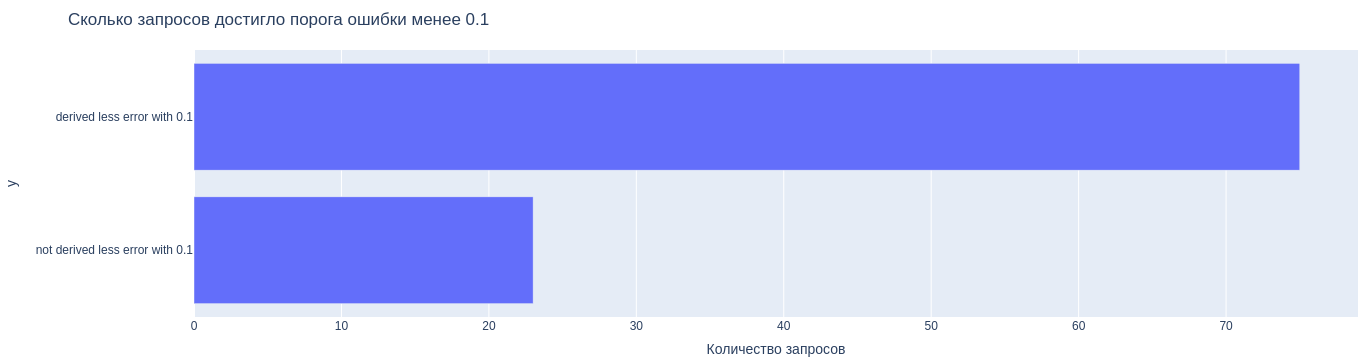

In [61]:
fig = px.bar(x=ox, y=oy)
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, y = 0.4, xanchor="center"),
                  title="Сколько запросов достигло порога ошибки менее 0.1",
                  xaxis_title="Количество запросов",
                  margin=dict(l=0, r=0, t=50, b=0))

In [62]:
lst_min_val_without_aqo = []
lst_min_iter_without_aqo = []
for i in df_stat.itertuples(index=False):
    min_val = 100000
    iteration = -1
    for k,val in enumerate(i.cardinality_error_without_aqo_split):
        if val < 0.1:
            if min_val>val:
                min_val = val
                iteration = k
    lst_min_val_without_aqo.append(min_val)
    lst_min_iter_without_aqo.append(iteration)

In [63]:
df_stat['min_iter_card_without'] = lst_min_iter_without_aqo

In [64]:
df_stat['lst_min_val_without_aqo'] = lst_min_val_without_aqo

In [65]:
len(df_stat[df_stat['min_iter_card_without']==-1])

98

In [66]:
len(df_stat[df_stat['min_iter_card_without']>-1])

0

In [67]:
x = np.array(range(20))

In [68]:
lst_min_val_with_aqo = []
lst_min_iter_with_aqo = []
for i in df_stat.itertuples(index=False):
    min_val = 100000
    iteration = -1
    for k,val in enumerate(i.execution_time_with_aqo_split):
        if val < 0.1:
            if min_val>val:
                min_val = val
                iteration = k
    lst_min_val_with_aqo.append(min_val)
    lst_min_iter_with_aqo.append(iteration)

In [69]:
df_stat['min_iter_exec_with'] = lst_min_iter_with_aqo

In [70]:
df_stat['lst_min_exec_with_aqo'] = lst_min_val_with_aqo

In [71]:
df_stat['min_iter_exec_with']

0    -1
1    -1
2    -1
3    -1
4    -1
     ..
93    2
94   -1
95    4
96   -1
97    8
Name: min_iter_exec_with, Length: 98, dtype: int64

In [72]:
len(df_stat[df_stat['min_iter_exec_with']==-1])

72

In [73]:
len(df_stat[df_stat['min_iter_exec_with']>-1])

26

In [74]:
lst_min_val_without_aqo = []
lst_min_iter_without_aqo = []
for i in df_stat.itertuples(index=False):
    min_val = 100000
    iteration = -1
    for k,val in enumerate(i.execution_time_without_aqo_split):
        if val < 0.1:
            if min_val>val:
                min_val = val
                iteration = k
    lst_min_val_without_aqo.append(min_val)
    lst_min_iter_without_aqo.append(iteration)

In [75]:
df_stat['min_iter_exec_without'] = lst_min_iter_without_aqo

In [76]:
df_stat['lst_min_exec_without_aqo'] = lst_min_val_without_aqo

In [77]:
df_stat['queryid'] = df_stat['queryid'].astype(str)

In [78]:
df_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   queryid                              98 non-null     object 
 1   cardinality_error_without_aqo_split  98 non-null     object 
 2   cardinality_error_with_aqo_split     98 non-null     object 
 3   planning_time_without_aqo_split      98 non-null     object 
 4   planning_time_with_aqo_split         98 non-null     object 
 5   execution_time_without_aqo_split     98 non-null     object 
 6   execution_time_with_aqo_split        98 non-null     object 
 7   executions_with_aqo                  98 non-null     int64  
 8   executions_without_aqo               98 non-null     int64  
 9   min_iter_card_with                   98 non-null     int64  
 10  lst_min_val_with_aqo                 98 non-null     float64
 11  min_iter_card_without             

In [79]:
ox = df_stat['queryid'].to_list()
oy = df_stat['min_iter_card_with'].to_list()

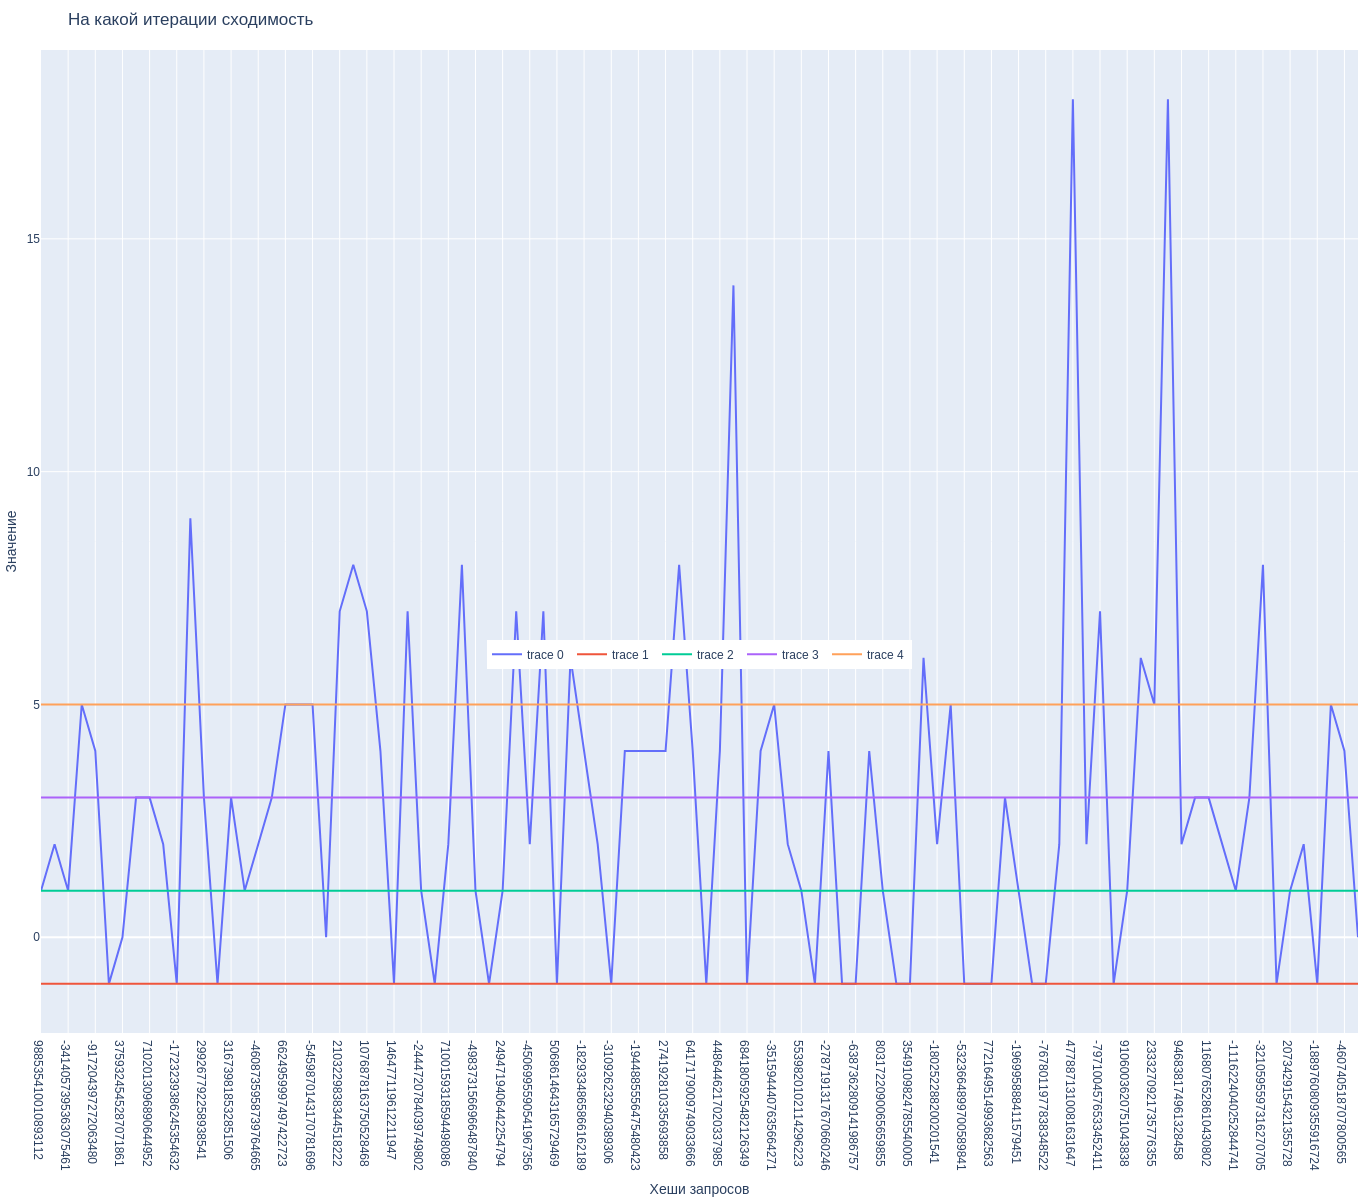

In [80]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = ox, y = oy))
fig.add_trace(go.Scatter(x = ox, y = [-1]*len(df_stat['min_iter_card_with'])))
fig.add_trace(go.Scatter(x = ox, y = [1]*len(df_stat['min_iter_card_with'])))
fig.add_trace(go.Scatter(x = ox, y = [3]*len(df_stat['min_iter_card_with'])))
fig.add_trace(go.Scatter(x = ox, y = [5]*len(df_stat['min_iter_card_with'])))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, y = 0.4, xanchor="center"),
                  title="На какой итерации сходимость",
                  xaxis_title="Хеши запросов",
                  yaxis_title="Значение",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

In [81]:
df_stat_sum = df_stat.copy()

In [82]:
lst_columns = ['cardinality_error_without_aqo_split', 'cardinality_error_with_aqo_split']

In [86]:
lst_columns_with = ['planning_time_with_aqo_split', 'execution_time_with_aqo_split']

In [87]:
lst_columns_without = ['planning_time_without_aqo_split', 'execution_time_without_aqo_split']

In [85]:
for i in lst_columns:
    df_stat_sum = functions.last_errors(df_stat, i)

In [94]:
for i in lst_columns_with:
    df_stat_sum = functions.sum_errors(df_stat, i)

In [95]:
for i in lst_columns_without:
    df_stat_sum = functions.sum_errors(df_stat, i)

In [96]:
df_stat_sum

,queryid,cardinality_error_without_aqo_split,cardinality_error_with_aqo_split,planning_time_without_aqo_split,planning_time_with_aqo_split,execution_time_without_aqo_split,execution_time_with_aqo_split,executions_with_aqo,executions_without_aqo,min_iter_card_with,lst_min_val_with_aqo,min_iter_card_without,lst_min_val_without_aqo,min_iter_exec_with,lst_min_exec_with_aqo,min_iter_exec_without,lst_min_exec_without_aqo
0,988535410010893112,1.172990,0.000000,0.012401,0.029772,0.092219,0.138994,10,1,1,0.000000e+00,-1,100000,-1,100000.000000,0,0.092219
1,-6651533820180303979,0.712949,0.000000,0.021290,0.033519,0.645730,0.330784,10,1,2,0.000000e+00,-1,100000,-1,100000.000000,-1,100000.000000
2,-3414057395363075461,0.914299,0.000000,0.008943,0.016652,0.179501,0.187803,10,1,1,7.701635e-02,-1,100000,-1,100000.000000,-1,100000.000000
3,3350265702090035455,3.324306,0.000000,0.031074,0.059175,61.923453,61.124971,10,1,5,3.999210e-08,-1,100000,-1,100000.000000,-1,100000.000000
4,-917204397272063480,3.259903,0.055073,0.024932,0.033134,32.650785,19.521501,10,1,4,8.274325e-02,-1,100000,-1,100000.000000,-1,100000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,-6885312641126422993,2.431867,0.000000,0.007239,0.013360,0.103223,0.116715,10,1,2,0.000000e+00,-1,100000,2,0.099772,-1,100000.000000
94,-1889760809355916724,2.837364,0.967703,0.243446,2.826535,1.817958,4.217003,10,1,-1,1.000000e+05,-1,100000,-1,100000.000000,-1,100000.000000
95,-6571914703387389993,1.981759,0.005660,0.314045,5.535178,9.564133,1.064662,10,1,5,3.314228e-02,-1,100000,4,0.041550,-1,100000.000000
96,-460740518707800565,0.927672,0.000000,0.073120,0.126801,0.700439,0.618877,10,1,4,0.000000e+00,-1,100000,-1,100000.000000,-1,100000.000000


In [97]:
for i in lst_columns_with:
    df_stat_sum[i] = df_stat_sum[i] / df_stat_sum['executions_with_aqo']

In [98]:
for i in lst_columns_without:
    df_stat_sum[i] = df_stat_sum[i] / df_stat_sum['executions_without_aqo']

In [99]:
df_stat_sum

,queryid,cardinality_error_without_aqo_split,cardinality_error_with_aqo_split,planning_time_without_aqo_split,planning_time_with_aqo_split,execution_time_without_aqo_split,execution_time_with_aqo_split,executions_with_aqo,executions_without_aqo,min_iter_card_with,lst_min_val_with_aqo,min_iter_card_without,lst_min_val_without_aqo,min_iter_exec_with,lst_min_exec_with_aqo,min_iter_exec_without,lst_min_exec_without_aqo
0,988535410010893112,1.172990,0.000000,0.012401,0.002977,0.092219,0.013899,10,1,1,0.000000e+00,-1,100000,-1,100000.000000,0,0.092219
1,-6651533820180303979,0.712949,0.000000,0.021290,0.003352,0.645730,0.033078,10,1,2,0.000000e+00,-1,100000,-1,100000.000000,-1,100000.000000
2,-3414057395363075461,0.914299,0.000000,0.008943,0.001665,0.179501,0.018780,10,1,1,7.701635e-02,-1,100000,-1,100000.000000,-1,100000.000000
3,3350265702090035455,3.324306,0.000000,0.031074,0.005918,61.923453,6.112497,10,1,5,3.999210e-08,-1,100000,-1,100000.000000,-1,100000.000000
4,-917204397272063480,3.259903,0.055073,0.024932,0.003313,32.650785,1.952150,10,1,4,8.274325e-02,-1,100000,-1,100000.000000,-1,100000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,-6885312641126422993,2.431867,0.000000,0.007239,0.001336,0.103223,0.011671,10,1,2,0.000000e+00,-1,100000,2,0.099772,-1,100000.000000
94,-1889760809355916724,2.837364,0.967703,0.243446,0.282653,1.817958,0.421700,10,1,-1,1.000000e+05,-1,100000,-1,100000.000000,-1,100000.000000
95,-6571914703387389993,1.981759,0.005660,0.314045,0.553518,9.564133,0.106466,10,1,5,3.314228e-02,-1,100000,4,0.041550,-1,100000.000000
96,-460740518707800565,0.927672,0.000000,0.073120,0.012680,0.700439,0.061888,10,1,4,0.000000e+00,-1,100000,-1,100000.000000,-1,100000.000000


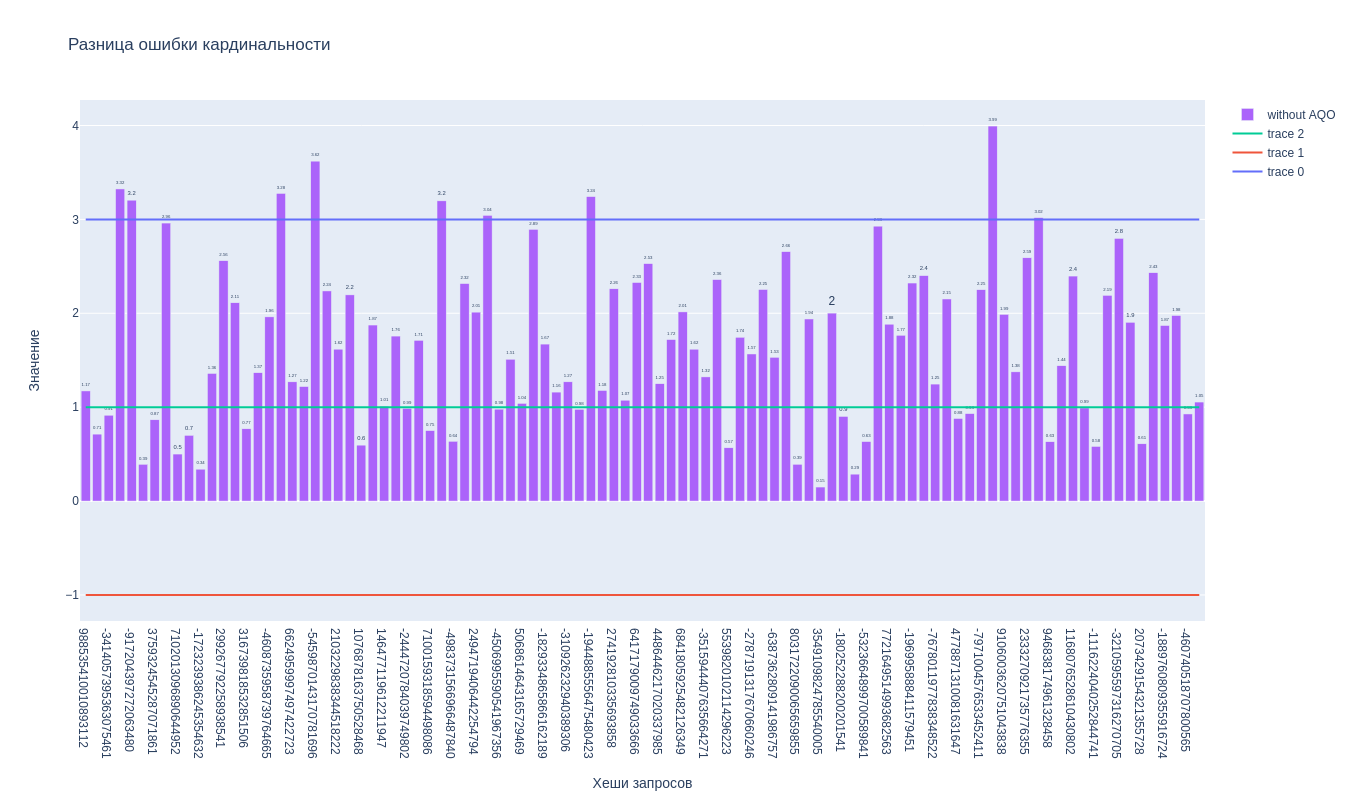

In [116]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [3]*len(df_stat_sum['cardinality_error_without_aqo_split'])))
fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [-1]*len(df_stat_sum['cardinality_error_without_aqo_split'])))
fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [1]*len(df_stat_sum['cardinality_error_without_aqo_split'])))
fig.add_trace(go.Bar(name = 'without AQO', x=df_stat_sum['queryid'], y=df_stat_sum['cardinality_error_without_aqo_split']-df_stat_sum['cardinality_error_with_aqo_split'],
                    text=round(df_stat_sum['cardinality_error_without_aqo_split']-df_stat_sum['cardinality_error_with_aqo_split'],2), textposition='outside'))
#fig.add_trace(go.Bar(name='with AQO', x=df_stat_sum['queryid'], y=df_stat_sum['cardinality_error_with_aqo_split'],
#                    text=round(df_stat_sum['cardinality_error_without_aqo_split'],2), textposition='outside'))
fig.update_layout(barmode='stack', width=3000, height = 800, title="Разница ошибки кардинальности",
                  xaxis_title="Хеши запросов",
                  yaxis_title="Значение",)
fig.show()

In [139]:
df_stat_sum_0_3=df_stat_sum[(df_stat_sum['execution_time_without_aqo_split']-df_stat_sum['execution_time_with_aqo_split']>4) & 
                            (df_stat_sum['execution_time_without_aqo_split']-df_stat_sum['execution_time_with_aqo_split']<=1000)]

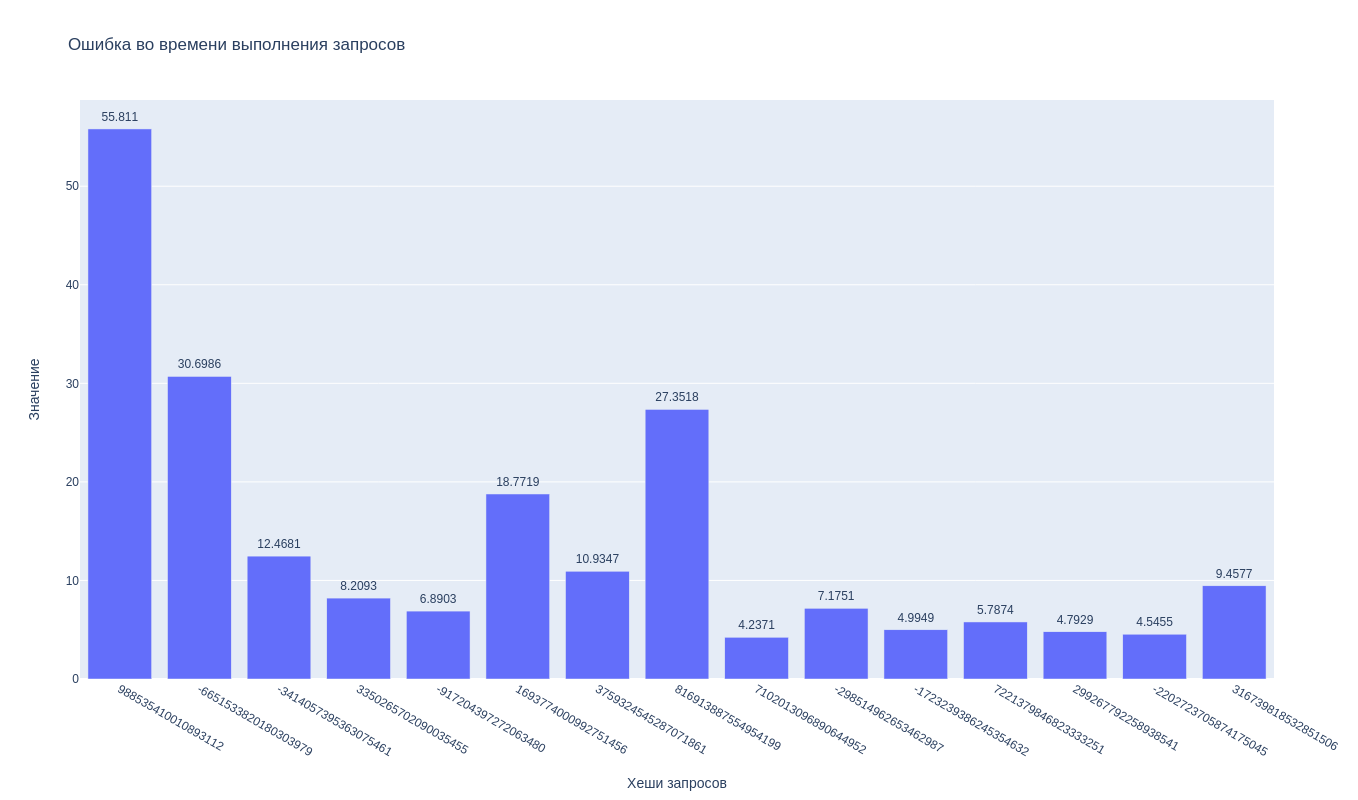

In [140]:
fig = go.Figure()
#fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [3]*len(df_stat_sum_0_3['cardinality_error_without_aqo_split'])))
#fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [-1]*len(df_stat_sum_0_3['cardinality_error_without_aqo_split'])))
#fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [1]*len(df_stat_sum_0_3['cardinality_error_without_aqo_split'])))
fig.add_trace(go.Bar(name = 'without AQO', x=df_stat_sum['queryid'], y=df_stat_sum_0_3['execution_time_without_aqo_split']-df_stat_sum_0_3['execution_time_with_aqo_split'],
                    text=round(df_stat_sum_0_3['execution_time_without_aqo_split']-df_stat_sum_0_3['execution_time_with_aqo_split'],4), textposition='outside'))
fig.update_layout(barmode='stack', width=3000, height = 800, title="Ошибка во времени выполнения запросов",
                  xaxis_title="Хеши запросов",
                  yaxis_title="Значение",)
fig.show()

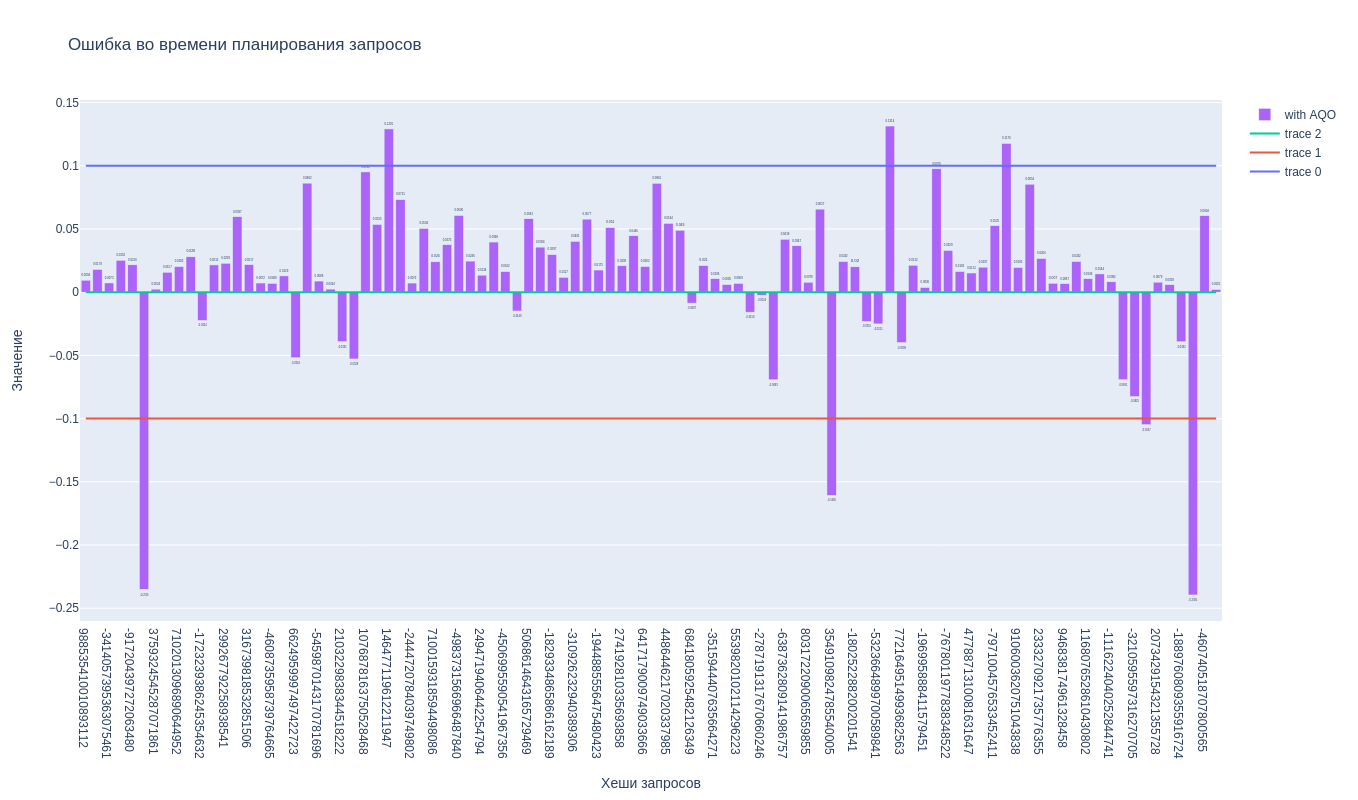

In [119]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [0.1]*len(df_stat_sum['cardinality_error_without_aqo_split'])))
fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [-0.1]*len(df_stat_sum['cardinality_error_without_aqo_split'])))
fig.add_trace(go.Scatter(x = df_stat_sum['queryid'], y = [0]*len(df_stat_sum['cardinality_error_without_aqo_split'])))
fig.add_trace(go.Bar(name='with AQO', x=df_stat_sum['queryid'], y=df_stat_sum['planning_time_without_aqo_split']-df_stat_sum['planning_time_with_aqo_split'],
                    text=round(df_stat_sum['planning_time_without_aqo_split']-df_stat_sum['planning_time_with_aqo_split'],4), textposition='outside'))
fig.update_layout(barmode='stack', width=3000, height = 800, title="Ошибка во времени планирования запросов",
                  xaxis_title="Хеши запросов",
                  yaxis_title="Значение",)
fig.show()